<a href="https://colab.research.google.com/github/Xw-Jia/2019_SaveYourself_GetOffer/blob/master/%E4%B9%A6%E7%9B%AE%E6%95%B4%E7%90%86/Python%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0/Part2%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0%E5%AE%9E%E8%B7%B5/%E4%BB%A3%E7%A0%81/6_3_advanced_usage_of_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy==1.16.2

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2019-05-05 14:35:13--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.84.59
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.84.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  --.-KB/s    in 0.1s    

2019-05-05 14:35:13 (88.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [3]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [5]:
import os

data_dir = '/content/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))
#可以知道，有420551行数据，每行是一个timestep，记录一个日期和14个天气特征

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [0]:
'''
数据转换成Numpy数组
'''
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] #索引0是time
    float_data[i, :] = values

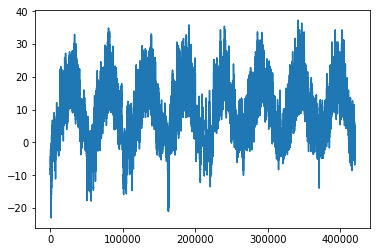

In [7]:

from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()
#所有的温度数据(摄氏度)

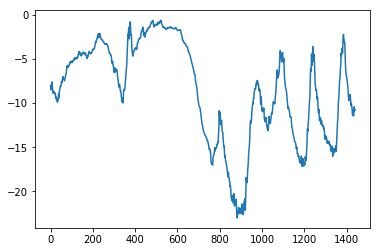

In [8]:
#前10天的温度数据，10分钟记录一个
plt.plot(range(1440), temp[:1440])
plt.show()

In [0]:
'''
如果按天作为观察尺度，是否可以根据前几个月的数据，预测接下来的温度？？

准备数据：
lookback = 720：给定过去5天的数据
steps = 6： 每一小时记录一个数据点
delay = 144 ： 目标是未来24小时之后的数据
'''
#1. 数据标准化，归一化，不同的特征取值范围调整

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [0]:
'''
函数：当前浮点数为输入，从最近数据中生成数据batch，同时生成未来的目标数据target

数据是高度冗余的，第N个样本和第N+1个样本大部分timestep相同，所有，显式保存每个样本很浪费，所以，使用原始数据及时生成样本
'''
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets   #函数变成了生成器函数，它的实例返回一个可迭代对象

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 生成验证集要从val_gen抽取多少次
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 一种基于非机器学习的baseline
：预测24小时后的温度等于目前的温度

用平均绝对误差(MAE)来评估：

`np.mean(np.abs(preds - targets))`


In [13]:
'''
计算常识baseline的MAE
'''
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [14]:
'''
改进baseline，使用一个简单的NN
'''
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 13s 25ms/step - loss: 1.2409 - val_loss: 0.7789
Epoch 2/20
500/500 [==============================] - 11s 23ms/step - loss: 0.4472 - val_loss: 0.3783
Epoch 3/20
500/500 [==============================] - 11s 23ms/step - loss: 0.3043 - val_loss: 0.3118
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2699 - val_loss: 0.3030
Epoch 5/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2580 - val_loss: 0.3388
Epoch 6/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2482 - val_loss: 0.3293
Epoch 7/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2413 - val_loss: 0.3267
Epoch 8/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2349 - val_loss: 0.3202
Epoch 9/20
500/500 [==============================] - 11s 23ms/s

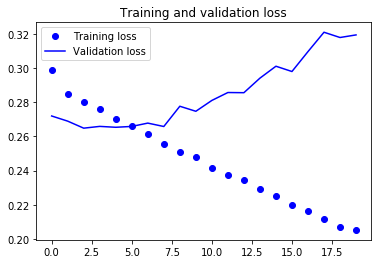

In [17]:

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

发现验证损失甚至不能超过baseline的mae，所以学习效果不好

In [16]:
'''
上一个Dense的方法，首先把时间序列展平，丢弃了时间的概念
尝试使用RNN--GRU
'''
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 171s 341ms/step - loss: 0.2986 - val_loss: 0.2719
Epoch 2/20
500/500 [==============================] - 173s 345ms/step - loss: 0.2846 - val_loss: 0.2689
Epoch 3/20
500/500 [==============================] - 172s 344ms/step - loss: 0.2800 - val_loss: 0.2648
Epoch 4/20
500/500 [==============================] - 175s 349ms/step - loss: 0.2760 - val_loss: 0.2658
Epoch 5/20
500/500 [==============================] - 175s 349ms/step - loss: 0.2702 - val_loss: 0.2653
Epoch 6/20
500/500 [==============================] - 174s 348ms/step - loss: 0.2662 - val_loss: 0.2658
Epoch 7/20
500/500 [==============================] - 175s 350ms/step - loss: 0.2612 - val_loss: 0.2678
Epoch 8/20
500/500 [==============================] - 173s 347ms/step - loss: 0.2556 - val_loss: 0.2658
Epoch 9/20
500/500 [==============================] - 175s 350ms/step - loss: 0.2508 - val_loss: 0.2776
Epoch 10/20
500/500 [==============================] - 173s 346m

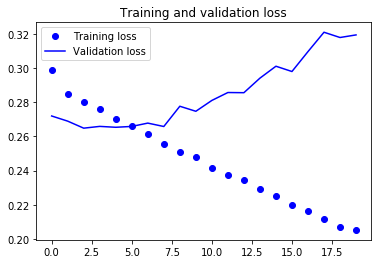

In [18]:
#画图
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
'''
使用循环Dropout降低过拟合
在循环层前面加Dropout，妨碍学习，没有帮助
RNN中使用Dropout的方法：对每个timestep使用相同的Dropout mask(相同模式的舍弃单元)，不让dropout mask随时间步变化随机变化
另外，为了对LSTM/GRU等循环层得到的表示做正则化，应该将不随时间变化的dropout mask应用在层的内部循环激活
Keras RNN--Dropout有两个参数，dropout和recurrent_dropout
'''
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/40
500/500 [==============================] - 199s 399ms/step - loss: 0.3390 - val_loss: 0.2817
Epoch 2/40
500/500 [==============================] - 199s 397ms/step - loss: 0.3150 - val_loss: 0.2740
Epoch 3/40
500/500 [==============================] - 199s 398ms/step - loss: 0.3080 - val_loss: 0.2779
Epoch 4/40
500/500 [==============================] - 201s 402ms/step - loss: 0.3040 - val_loss: 0.2687
Epoch 5/40
500/500 [==============================] - 198s 397ms/step - loss: 0.2990 - val_loss: 0.2692
Epoch 6/40
500/500 [==============================] - 202s 404ms/step - loss: 0.2969 - val_loss: 0.2676
Epoch 7/40
500/500 [==============================] - 198s 395ms/step - loss: 0.2935 - val_loss: 0.2692
Epoch 8/40
500/500 [==============================] - 199s 398ms/step - loss: 0.2931 - val_loss: 0.2653
Epoch 9/40
500/500 [==============================] -

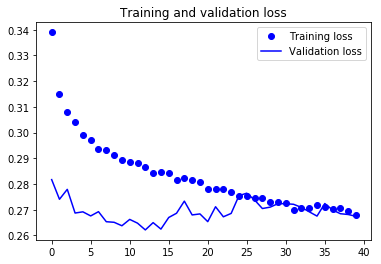

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
'''
循环层堆叠，增加深度
注意，中间的循环层要输出所有的隐向量，return_sequences=True
还有，为什么第一个GRU可以不用激活函数？？---> RNN没有指定的话，是tanh，Relu容易使神经元坏死，
当层数增多，学习率降低时，可以人为指定其他激活函数
'''
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 388s 776ms/step - loss: 0.3365 - val_loss: 0.2813
Epoch 2/20
500/500 [==============================] - 382s 763ms/step - loss: 0.3129 - val_loss: 0.2712
Epoch 3/20
500/500 [==============================] - 380s 761ms/step - loss: 0.3059 - val_loss: 0.2699
Epoch 4/20
500/500 [==============================] - 381s 763ms/step - loss: 0.3018 - val_loss: 0.2708
Epoch 5/20
500/500 [==============================] - 379s 757ms/step - loss: 0.2985 - val_loss: 0.2688
Epoch 6/20
500/500 [==============================] - 375s 750ms/step - loss: 0.2961 - val_loss: 0.2686
Epoch 7/20
500/500 [==============================] - 378s 756ms/step - loss: 0.2918 - val_loss: 0.2670
Epoch 8/20
500/500 [==============================] - 377s 754ms/step - loss: 0.2912 - val_loss: 0.2708
Epoch 9/20
500/500 [==============================] - 377s 753ms/step - loss: 0.2906 - val_loss: 0.2777
Epoch 10/20
500/500 [==============================] - 375s 751m

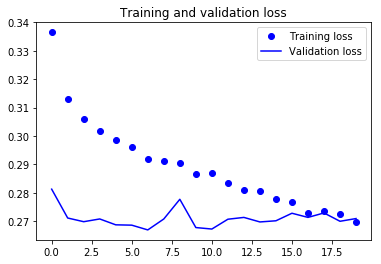

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从结果看，增加了这个循环层，改进并不明显，但是过拟合仍然不是很严重：
1. 增加每层大小试试
2. 说明提高网络能力的回报在减小，也就是性价比降低了

In [0]:
'''
使用双向RNN

函数: 数据生成器的变体，将输入序列沿时间维度反转
'''
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [0]:
'''
天气数据反向喂入GRU，效果不如正向
'''
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [0]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
'''
IMDB数据反向，喂入LSTM，发现和正向效果差不多
'''
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [0]:

from keras import backend as K
K.clear_session()

In [0]:
'''
IMDB
训练一个bi-RNN
需要layers.Bidirectional(layers.LSTM(32))
'''
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

In [0]:
'''
天气数据
训练Bi-GRU
'''
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

对于天气数据，强烈依赖于正向顺序，双向的结果和正向的结果差不多，信息只存在于正向所学习到的内容；

另外的调参方法：


1.   优化每个堆叠层的单元的个数
2.   调节RMSprop的学习率
3.   LSTM代替GRU
4.   RNN后面加更大的Dense层，或者多个Dense层




另外两个对NLP有用的概念：


1.   循环注意(recurrent attention)
2.   序列掩码(sequence masking)



重新回顾RNN Dropout mask：


1.   St在每个时间进行相同的mask，而基础的Dropout在循环层是没有舍弃的，支队输入和输出进行舍弃，但是舍弃也是随机的
2.   RNN的Dropout每个时间会舍弃相同的单元，包括输入、输出、和循环
3.   含义：基于词的dropout对应于从句子中舍弃词，迫使模型不依赖于单个词完成任务

